In [ ]:
!pip install contractions
!pip install tqdm
!pip install tensorflow_hub
!pip install bert-for-tf2
!pip install sentencepiece

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.7/110.7 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 kB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for bert-for-tf2: filename=bert_for_tf2-0.14.9-py3-none-any.whl size=30510 sha256=eed192806894ae5328e1de45c964a1af84cc72ddfdb6f01ae0a7e73e1278753f
  Stored in directory: /root/.cache/pip/wheels/d8/da/50/126d7b8416d9a0e6bf876935c2219a71e72a6529c25e150c56
  Created wheel for params-flow: filename=params_flow-0.8.2-py3-none-any.whl size=19455 sha256=7b7c02c0fb1ba42e4f16f9b2e32bb997859c0c71d1c7cc1ad93f632fdeb8e78e
  Stored in directory: /root/.cache/pip/wheels/97/a8/d0/f7419404174976a2686bb98b5c30df01cc71445415f32db9e6
  Created wheel for py-params: filename=py_params-0.10.2-py3-none-any.whl size=7891 sha256=7b100

In [ ]:
import pandas as pd

'''
'overall' = 買家對產品的評分
'verified' = true
'reviewTime' = 評論的時間
'reviewerID' = 評論ID
'asin' = 產品ID
'style' = 產品的特徵
'reviewerName' = 評論ID的名字
'reviewText' = 評論的內容
'summary' = 評論內容的總結
'unixReviewTime' = 評論的格林威治時間
'''

fin = open('/Magazine_Subscriptions.json')

review_list=[]
for line in fin:
  d = eval(line,{'true':True,'false':False,'null':None})
  if 'reviewText' in d.keys() and 'summary' in d.keys():
      review_list.append([d['reviewerID'], d['asin'], d['overall'], d['reviewTime'], d['reviewText'], d['summary']])
df = pd.DataFrame(review_list, columns=['user_id', 'item_id', 'score','reviewTime', 'review_text','summary'])
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89640 entries, 0 to 89639
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   user_id      89640 non-null  object 
 1   item_id      89640 non-null  object 
 2   score        89640 non-null  float64
 3   reviewTime   89640 non-null  object 
 4   review_text  89640 non-null  object 
 5   summary      89640 non-null  object 
dtypes: float64(1), object(5)
memory usage: 4.1+ MB
None


In [ ]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import random as rn
import seaborn as sns
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
from collections import Counter
from PIL import Image

from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.model_selection import train_test_split
import pandas as pd
import tensorflow as tf
import tensorflow_hub as tf_hub
import time
import numpy as np
import os
import tqdm
from tensorflow.keras import backend as K
#os.environ["CUDA_VISIBLE_DEVICES"] = "0"

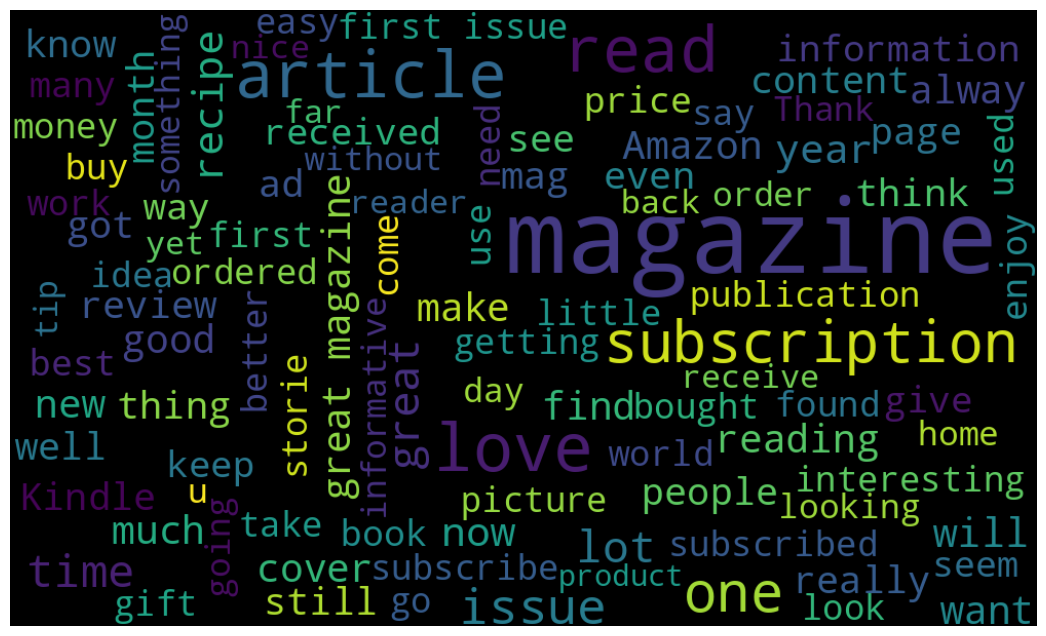

In [ ]:
txt = ' '.join(rev for rev in df.review_text)
plt.figure(figsize=(15,8))

wordcloud = WordCloud(
            background_color = 'black',
            max_font_size = 100,
            max_words = 100,
            width = 1000,
            height = 600
            ).generate(txt)


plt.imshow(wordcloud,interpolation = 'bilinear')
plt.axis('off')
plt.show()

In [ ]:
def score_round(x):
    if x>=3:
        return 1
    else:
        return 0

In [ ]:
df['review_score']= df.score.apply(score_round)
print(df.head())

          user_id     item_id  score   reviewTime  \
0   AH2IFH762VY5U  B00005N7P0    5.0   11 8, 2001   
1   AOSFI0JEYU4XM  B00005N7P0    5.0  10 31, 2001   
2  A3JPFWKS83R49V  B00005N7OJ    3.0  03 24, 2007   
3  A19FKU6JZQ2ECJ  B00005N7OJ    5.0  11 10, 2006   
4  A25MDGOMZ2GALN  B00005N7P0    5.0  07 14, 2014   

                                         review_text  \
0  for computer enthusiast, MaxPC is a welcome si...   
1  Thank god this is not a Ziff Davis publication...   
2  Antiques Magazine is a publication made for an...   
3  This beautiful magazine is in itself a work of...   
4                          A great read every issue.   

                                           summary  review_score  
0           AVID READER SINCE "boot"  WAS THE NAME             1  
1                               The straight scoop             1  
2  Antiques Magazine is Good, but not for Everyone             1  
3                           THE  DISCERNING READER             1  
4        

In [ ]:
df.review_text = df.review_text.astype('str')
df.summary = df.summary.astype('str')

In [ ]:
positive = df[df['review_score']==1]
negative = df[df['review_score']==0]

In [ ]:
df.isnull().sum()

user_id         0
item_id         0
score           0
reviewTime      0
review_text     0
summary         0
review_score    0
dtype: int64

In [ ]:
def clean(raw):
    """ Remove hyperlinks and markup """
    result = re.sub("<[a][^>]*>(.+?)</[a]>", 'Link.', raw)
    result = re.sub('&gt;', "", result)#'>'
    result = re.sub('&lt;', "", result)#'<'
    result = re.sub('&#x27;', "'", result)#'''
    result = re.sub('&quot;', '"', result)#'"'
    result = re.sub('&apos;', '"', result)#'''
    result = re.sub('&#x2F;', "", result)#'/'
    result = re.sub('<p>', "", result)#''
    result = re.sub('</p>', "", result)#''
    result = re.sub('<i>', "", result)#''
    result = re.sub('</i>', "", result)#''
    result = re.sub("\n", "", result)
    return result
df['review_text'] = df['review_text'].apply(clean)

In [ ]:
def remove_num(texts):
   output = re.sub(r'\d+', '', texts)
   return output
df['review_text'] = df['review_text'].apply(remove_num)

In [ ]:
def remove_mouse(texts):
   output = re.sub(r"[\w\.\-\_]+@[\w\.\-\_]+", '', texts)
   return output
df['review_text'] = df['review_text'].apply(remove_mouse)

In [ ]:
import re
def remove_symbols(texts):
    output = re.sub(r"[^a-zA-Z0-9]+", ' ', texts)
    return output
df['review_text'] = df['review_text'].apply(remove_symbols)

In [ ]:
import re
def unify_whitespaces(texts):
    cleaned_string = re.sub(' +', ' ', texts)#刪掉多餘的空格
    return cleaned_string
df['review_text'] = df['review_text'].apply(unify_whitespaces)

In [ ]:
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')

stop = set(stopwords.words('english'))

def remove_stopword(texts):
   text=[word.lower() for word in texts.split() if word.lower() not in stop]
   return " ".join(text)
#text = "There is an apple on the table."
#remove_stopword(text)
df['review_text'] = df['review_text'].apply(remove_stopword)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
def remove_emoji(texts):
    output = re.compile("["
            u"\U0001F600-\U0001F64F"  # emoticons
            u"\U0001F300-\U0001F5FF"  # symbols & pictographs
            u"\U0001F680-\U0001F6FF"  # transport & map symbols
            u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                              "]+", flags=re.UNICODE)
    return output.sub(r'', texts)
df['review_text'] = df['review_text'].apply(remove_emoji)

In [ ]:
df[['review_text']].head(20)

,review_text
0,computer enthusiast maxpc welcome sight mailbo...
1,thank god ziff davis publication maxpc actuall...
2,antiques magazine publication made antique lov...
3,beautiful magazine work art quality every page...
4,great read every issue
5,magazine great times technology magazines new ...
6,read maximum pc mpc many years articles techni...
7,ordered magazine grandson going deploy technol...
8,subscribed nook version years thoroughly enjoy...
9,old computer advice help maximize computer per...


In [ ]:
#training_text, test_text, training_labels, test_labels = train_test_split(reviews, labels, test_size=.4)
#validation_text, holdout_text, validation_labels, holdout_labels = train_test_split(test_text, test_labels, test_size=.4)

training_text = reviews[:50000]
validation_text = reviews[50000:70000]
test_text = reviews[70000:]

training_labels = labels[:50000]
validation_labels = labels[50000:70000]
test_labels = labels[70000:]

In [ ]:
from imblearn.over_sampling import BorderlineSMOTE, SMOTE, ADASYN

sm = BorderlineSMOTE(sampling_strategy='minority')
training_text_s, training_labels = sm.fit_resample(training_text, training_labels)
validation_text_s, validation_labels = sm.fit_resample(validation_text, validation_labels)

In [ ]:
training_text_s = training_text_s.values.tolist()
validation_text_s = validation_text_s.values.tolist()
test_text = test_text.values.tolist()

training_labels = training_labels.tolist()
validation_labels = validation_labels.tolist()
test_labels = test_labels.tolist()

In [ ]:
#reviews = df["review_text"].values.tolist()
#labels = df["review_score"].tolist()

In [ ]:
class PaddingInputExample(object):
  pass

class InputExample(object):
    """A single training/test example for simple sequence classification."""

    def __init__(self, guid, text_a, text_b=None, label=None):

        """Constructs a InputExample.
    Args:
      guid: Unique id for the example.
      text_a: string. The untokenized text of the first sequence. For single
        sequence tasks, only this sequence must be specified.
      text_b: (Optional) string. The untokenized text of the second sequence.
        Only must be specified for sequence pair tasks.
      label: (Optional) string. The label of the example. This should be
        specified for train and dev examples, but not for test examples.
    """
        self.guid = guid
        self.text_a = text_a
        self.text_b = text_b
        self.label = label

In [ ]:
from bert import tokenization
import bert
BertTokenizer = bert.bert_tokenization.FullTokenizer
bert_layer = tf_hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1",
                            trainable=False)
vocabulary_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
to_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = BertTokenizer(vocabulary_file, to_lower_case)

# Test tokenizer
tokenizer.tokenize("don't be so judgmental")

['don', "'", 't', 'be', 'so', 'judgment', '##al']

In [ ]:
def convert_text_to_examples(texts, labels):
    """Create InputExamples"""
    InputExamples = []
    for text, label in zip(texts, labels):
        InputExamples.append(
            InputExample(guid=None, text_a=text, text_b=None, label=label)
        )
    return InputExamples

In [ ]:
def convert_single_example(tokenizer, example, max_seq_length=256):
    """Converts a single `InputExample` into a single `InputFeatures`."""

    if isinstance(example, PaddingInputExample):
        input_ids = [0] * max_seq_length
        input_mask = [0] * max_seq_length
        segment_ids = [0] * max_seq_length
        label = 0
        return input_ids, input_mask, segment_ids, label

    tokens_a = tokenizer.tokenize(example.text_a)
    if len(tokens_a) > max_seq_length - 2:
        tokens_a = tokens_a[0 : (max_seq_length - 2)]

    tokens = []
    segment_ids = []
    tokens.append("[CLS]")
    segment_ids.append(0)
    for token in tokens_a:
        tokens.append(token)
        segment_ids.append(0)
    tokens.append("[SEP]")
    segment_ids.append(0)

    input_ids = tokenizer.convert_tokens_to_ids(tokens)

    # The mask has 1 for real tokens and 0 for padding tokens. Only real
    # tokens are attended to.
    input_mask = [1] * len(input_ids)

    # Zero-pad up to the sequence length.
    while len(input_ids) < max_seq_length:
        input_ids.append(0)
        input_mask.append(0)
        segment_ids.append(0)

    assert len(input_ids) == max_seq_length
    assert len(input_mask) == max_seq_length
    assert len(segment_ids) == max_seq_length

    return input_ids, input_mask, segment_ids, example.label

def convert_examples_to_features(tokenizer, examples, max_seq_length=256):
    """Convert a set of `InputExample`s to a list of `InputFeatures`."""

    input_ids, input_masks, segment_ids, labels = [], [], [], []
    for example in tqdm.tqdm(examples, desc="Converting examples to features"):
        input_id, input_mask, segment_id, label = convert_single_example(
            tokenizer, example, max_seq_length
        )
        input_ids.append(input_id)
        input_masks.append(input_mask)
        segment_ids.append(segment_id)
        labels.append(label)
    return (
        np.array(input_ids),
        np.array(input_masks),
        np.array(segment_ids),
        np.array(labels).reshape(-1, 1),
    )

In [ ]:
# Convert data to InputExample format
train_examples = convert_text_to_examples(training_text, training_labels)
val_examples = convert_text_to_examples(validation_text, validation_labels)
test_examples = convert_text_to_examples(holdout_text, holdout_labels)

In [ ]:
MAX_SEQ_LENGTH = 512

(train_input_ids, train_input_masks,
 train_segment_ids, train_labels) =  convert_examples_to_features(tokenizer=tokenizer,
                                                                  examples=train_examples,
                                                                  max_seq_length=MAX_SEQ_LENGTH)

(val_input_ids, val_input_masks,
 val_segment_ids, val_labels) =  convert_examples_to_features(tokenizer=tokenizer,
                                                              examples=val_examples,
                                                              max_seq_length=MAX_SEQ_LENGTH)

(test_input_ids, test_input_masks,
 test_segment_ids, test_labels) =  convert_examples_to_features(tokenizer=tokenizer,
                                                                examples=test_examples,
                                                                max_seq_length=MAX_SEQ_LENGTH)

Converting examples to features: 100%|██████████| 14343/14343 [00:08<00:00, 1718.27it/s]


In [ ]:
def build_model(bert_layer, max_len=512):
    input_word_ids = tf.keras.layers.Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = tf.keras.layers.Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    segment_ids = tf.keras.layers.Input(shape=(max_len,), dtype=tf.int32, name="segment_ids")

    _, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])
    clf_output = sequence_output[:, 0, :]
    dense = tf.keras.layers.Dense(256, activation='relu')(clf_output)
    out = tf.keras.layers.Dense(1, activation='sigmoid')(dense)

    model = tf.keras.models.Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=out)
    model.compile(tf.keras.optimizers.Adam(lr=1e-5), loss='binary_crossentropy', metrics=['accuracy'])

    return model

In [ ]:
model = build_model(bert_layer, max_len=512)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_word_ids (InputLayer  [(None, 512)]                0         []                            
 )                                                                                                
                                                                                                  
 input_mask (InputLayer)     [(None, 512)]                0         []                            
                                                                                                  
 segment_ids (InputLayer)    [(None, 512)]                0         []                            
                                                                                                  
 keras_layer (KerasLayer)    [(None, 768),                1094822   ['input_word_ids[0][0]',  

In [ ]:
BERT_PATH = "https://tfhub.dev/google/bert_uncased_L-12_H-768_A-12/1"
model = build_model(bert_path=BERT_PATH, max_seq_length=MAX_SEQ_LENGTH, n_fine_tune_encoders=10)

In [ ]:
model.summary()

In [ ]:
import keras
checkpoint = keras.callbacks.ModelCheckpoint('/model_smote.h5', monitor='val_loss', save_best_only=True)
model.fit(
    [train_input_ids, train_input_masks, train_segment_ids],
    train_labels,
    validation_data=([val_input_ids, val_input_masks, val_segment_ids], val_labels),
    epochs=2,
    batch_size=16,
    callbacks=[checkpoint],
    verbose=1
)

Epoch 1/2
3362/3362 [==============================] - ETA: 0s - loss: 0.3072 - accuracy: 0.8639

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3362/3362 [==============================] - 3414s 1s/step - loss: 0.3072 - accuracy: 0.8639 - val_loss: 0.2939 - val_accuracy: 0.8687
Epoch 2/2
3362/3362 [==============================] - 3415s 1s/step - loss: 0.2860 - accuracy: 0.8731 - val_loss: 0.2919 - val_accuracy: 0.8711


In [ ]:
test_predictions = model.predict(x=[test_input_ids,
                                    test_input_masks,
                                    test_segment_ids],
                                 batch_size=100,
                                 verbose=1)

144/144 [==============================] - 627s 4s/step


In [ ]:
test_predictions = test_predictions.ravel()

In [ ]:
test_pred_labels = [1 if prob > 0.5 else 0 for prob in test_predictions]

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

print('Classification Report:')
print(classification_report(y_true=test_labels, y_pred=test_pred_labels))

Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.57      0.62      2574
           1       0.91      0.94      0.92     11769

    accuracy                           0.87     14343
   macro avg       0.79      0.75      0.77     14343
weighted avg       0.87      0.87      0.87     14343



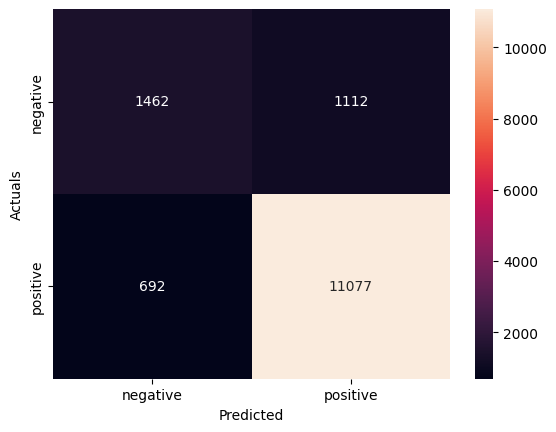

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

cm = tf.math.confusion_matrix(test_labels, test_pred_labels)

LABELS = ['negative', 'positive']
sns.heatmap(cm, annot=True, xticklabels=LABELS, yticklabels=LABELS, fmt='g')
xl = plt.xlabel("Predicted")
yl = plt.ylabel("Actuals")

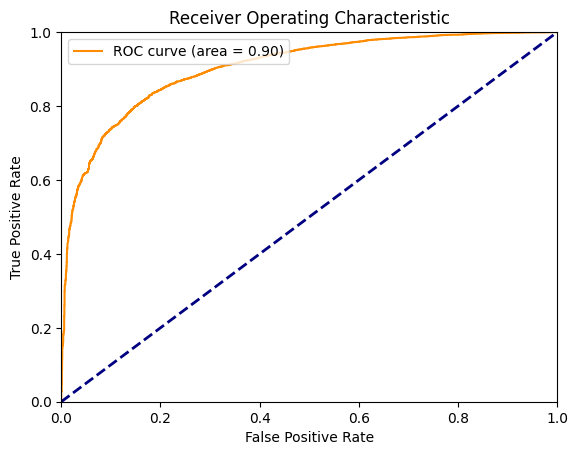

In [ ]:
import seaborn as sns
from sklearn.metrics import classification_report,confusion_matrix, roc_curve, roc_auc_score, auc, accuracy_score, f1_score, precision_score, recall_score

# Function to get roc curve
def get_roc (y_test,y_pred):
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    #Plot of a ROC curve
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="upper left")
    plt.show()
    return

get_roc (test_labels,test_predictions)